In [ ]:
# Installer PyTorch et PyTorch Geometric
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch-geometric
!pip install networkx matplotlib pandas


Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.9 MB/s eta 0:00:00


In [ ]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
import torch
from torch_geometric.data import Data


# Charger les données
file_path = "/content/data2.csv"  # Remplacer par le chemin correct
data = pd.read_csv(file_path, sep=';')

# Étape 1 : Calculer les distances entre tous les atomes
# Extraire les colonnes des coordonnées X, Y, Z

data.head(4)



,Snapshot,Atom Index,X,Y,Z,Energy
0,0,0,0.000000,0.000000,6.0,7.201712
1,0,1,2.800143,0.000000,6.0,7.201712
2,0,2,5.600286,0.000000,6.0,7.201712
3,0,3,0.000000,2.800143,6.0,7.201712


In [ ]:
# Extract X, Y, Z columns
coordinates = data[['X', 'Y', 'Z']].values

# Calculate the distance matrix
dist_matrix = distance_matrix(coordinates, coordinates)

# Display a portion of the distance matrix
print("\nMatrix of calculated distances:")
print(dist_matrix[:5, :5])  # Display a subset of the matrix



Matrix of calculated distances:
[[0.         2.80014285 5.60028571 2.80014285 3.96      ]
 [2.80014285 0.         2.80014285 3.96       2.80014285]
 [5.60028571 2.80014285 0.         6.26130977 3.96      ]
 [2.80014285 3.96       6.26130977 0.         2.80014285]
 [3.96       2.80014285 3.96       2.80014285 0.        ]]


In [ ]:
# Étape 2 : Créer les arêtes du graphe
# Définir un seuil pour considérer les voisins (par exemple, 3 angströms)
threshold = 3.0

# Obtenir les paires d'atomes connectés (i, j) où la distance est inférieure au seuil
edge_indices = np.where((dist_matrix < threshold) & (dist_matrix > 0))  # Exclure les distances nulles

# Transformer en format (source, target)
edges = np.array([edge_indices[0], edge_indices[1]])#la construction des arêtes du graphe à partir de la matrice des distances.

# Afficher un aperçu des arêtes
print("\nQuelques arêtes du graphe :")
print(edges[:, :10])  # Afficher les 10 premières connexions

# Étape 3 : Préparer les données pour le GNN
# Extraire les énergies comme attributs des nœuds
node_features = torch.tensor(data['Energy'].values, dtype=torch.float).view(-1, 1)  # Une seule feature par nœud

# Convertir les indices des arêtes en tenseur PyTorch
edge_index = torch.tensor(edges, dtype=torch.long)
edge_index



Quelques arêtes du graphe :
[[  0   0   0   0   0   0   0   0   0   0]
 [  1   3   9  64  66  72 127 129 135 190]]


tensor([[    0,     0,     0,  ..., 10079, 10079, 10079],
        [    1,     3,     9,  ..., 10070, 10076, 10078]])

In [ ]:
# Créer l'objet Data pour PyTorch Geometric
graph_data = Data(x=node_features, edge_index=edge_index)

# Étape 4 : Résumé des données
print("\nRésumé des données pour le GNN :")
print(f"Nombre de nœuds : {graph_data.num_nodes}")
print(f"Nombre d'arêtes : {graph_data.num_edges}")
print(f"Attributs des nœuds : {graph_data.x.shape}")

# Étape 5 : Enregistrer ou utiliser les données
# Enregistrer les données si nécessaire
torch.save(graph_data, "graph_data.pt")
print("\nLes données du graphe ont été enregistrées dans 'graph_data.pt'.")


Résumé des données pour le GNN :
Nombre de nœuds : 10080
Nombre d'arêtes : 11980800
Attributs des nœuds : torch.Size([10080, 1])

Les données du graphe ont été enregistrées dans 'graph_data.pt'.


<ipython-input-8-daab369028a6>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_data = torch.load(file_path)


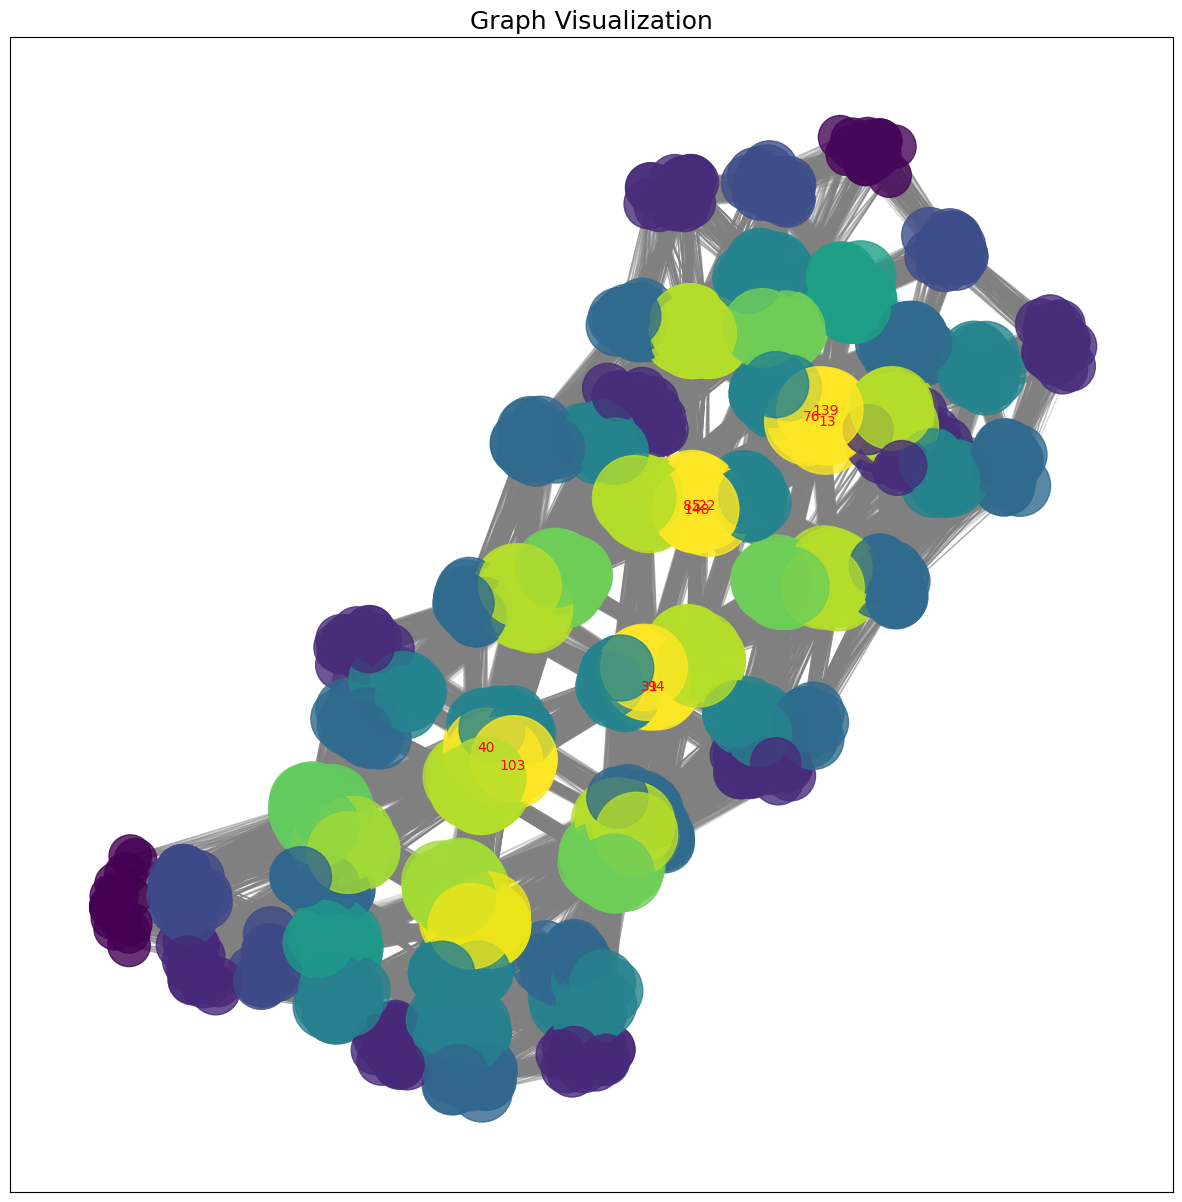

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Load the graph data
file_path = "graph_data.pt"  # Path to your .pt file
graph_data = torch.load(file_path)

# Convert the PyTorch Geometric graph to a NetworkX graph
G = to_networkx(graph_data, to_undirected=True)

# Configure the size of the image
plt.figure(figsize=(15, 15))

# Define a layout for organizing the nodes
pos = nx.spring_layout(G, seed=42, k=0.1)

# Sample a subset of nodes for better clarity if the graph is too large
if len(G.nodes()) > 1000:
    sampled_nodes = list(G.nodes())[:1000]
    G = G.subgraph(sampled_nodes)
    pos = {n: pos[n] for n in sampled_nodes}

# Define node sizes and colors
node_sizes = [20 * (G.degree(node) + 1) for node in G.nodes()]
node_colors = [G.degree(node) for node in G.nodes()]

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=node_sizes,
                       node_color=node_colors,
                       cmap=plt.cm.viridis, alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.3)

# Add labels to top 10 nodes by degree
top_degree_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]
top_labels = {node: str(node) for node, _ in top_degree_nodes}
nx.draw_networkx_labels(G, pos, labels=top_labels, font_size=10, font_color="red")

plt.title("Graph Visualization", fontsize=18)
plt.show()


In [ ]:
# Installer PyTorch et PyTorch Geometric
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch-geometric

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.7 MB/s eta 0:00:00


Valeurs manquantes par colonne :
Snapshot      0
Atom Index    0
X             0
Y             0
Z             0
Energy        0
dtype: int64


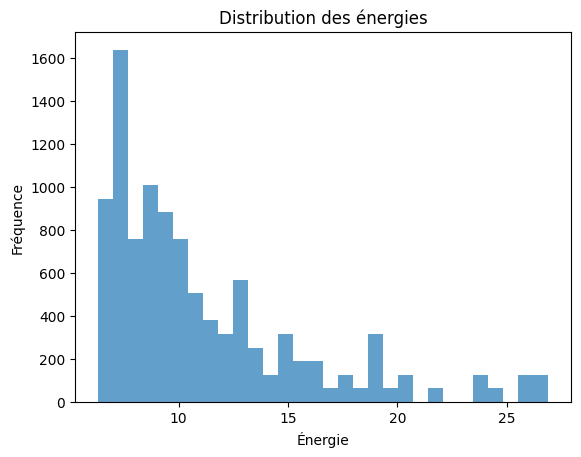

In [ ]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
import torch
from torch_geometric.data import Data


# Charger les données
file_path = "/content/data2.csv"  # Remplacer par le chemin correct
data = pd.read_csv(file_path, sep=';')

# Étape 1 : Calculer les distances entre tous les atomes
# Extraire les colonnes des coordonnées X, Y, Z

data.head(4)





# Vérifier les valeurs manquantes
print("Valeurs manquantes par colonne :")
print(data.isnull().sum())

# Extraction des colonnes nécessaires
# Ici, X, Y, Z représentent les coordonnées spatiales, et Energy est la valeur cible.
features = data[['X', 'Y', 'Z']]
target = data['Energy']

# Vérifier la distribution de l'énergie
import matplotlib.pyplot as plt
plt.hist(target, bins=30, alpha=0.7)
plt.title("Distribution des énergies")
plt.xlabel("Énergie")
plt.ylabel("Fréquence")
plt.show()
from sklearn.preprocessing import StandardScaler

scaler_y = StandardScaler()
data['Energy'] = scaler_y.fit_transform(data['Energy'].values.reshape(-1, 1))



In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Convertir les coordonnées X, Y, Z en un tableau numpy
coordinates = data[['X', 'Y', 'Z']].to_numpy()

# Définir le seuil de distance pour connecter les atomes
distance_threshold = 3.0  # Ajustez ce seuil selon vos besoins

# Calculer la matrice de distances
distance_matrix = cdist(coordinates, coordinates, metric='euclidean')

# Construire le graphe
graph = nx.Graph()
num_atoms = len(data)

# Ajouter les nœuds
for i in range(num_atoms):
    graph.add_node(i, pos=coordinates[i], energy=data.iloc[i]['Energy'])

# Ajouter les arêtes si la distance est inférieure au seuil
for i in range(num_atoms):
    for j in range(i + 1, num_atoms):
        if distance_matrix[i, j] <= distance_threshold:
            graph.add_edge(i, j, weight=distance_matrix[i, j])




In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch_geometric.data import Data, Dataset

# Conversion des données en graphe (comme vu précédemment)
def create_graph_data(data, distance_threshold=3.0):
    coordinates = data[['X', 'Y', 'Z']].to_numpy()
    num_atoms = len(data)
    distance_matrix = cdist(coordinates, coordinates, metric='euclidean')

    # Préparer les caractéristiques des nœuds (X, Y, Z) et les cibles (Energy)
    node_features = torch.tensor(coordinates, dtype=torch.float)
    node_targets = torch.tensor(data['Energy'].to_numpy(), dtype=torch.float)

    # Préparer les arêtes
    edge_index = torch.tensor(
        [[i, j] for i in range(num_atoms) for j in range(i + 1, num_atoms) if distance_matrix[i, j] <= distance_threshold],
        dtype=torch.long
    ).t()

    # Créer l'objet Data pour PyTorch Geometric
    return Data(x=node_features, edge_index=edge_index, y=node_targets)

# Diviser les données en entraînement, validation et test
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Créer des objets Data pour chaque ensemble
train_graph = create_graph_data(train_data)
val_graph = create_graph_data(val_data)
test_graph = create_graph_data(test_data)


In [ ]:
from torch_geometric.loader import DataLoader

# Créer des loaders pour chaque ensemble
batch_size = 1  # Vous pouvez ajuster la taille des lots
train_loader = DataLoader([train_graph], batch_size=batch_size, shuffle=True)
val_loader = DataLoader([val_graph], batch_size=batch_size, shuffle=False)
test_loader = DataLoader([test_graph], batch_size=batch_size, shuffle=False)


In [ ]:
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)  # Nouvelle couche
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = torch.mean(x, dim=0)
        x = self.fc(x)
        return x

# Initialisation du modèle
input_dim = 3  # X, Y, Z
hidden_dim = 64
output_dim = 1  # Énergie
model = GNNModel(input_dim, hidden_dim, output_dim)


In [ ]:
from torch.optim import Adam
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR


# Définir la fonction de perte et l'optimiseur
criterion = nn.L1Loss()  # MAE
optimizer = AdamW(model.parameters(), lr=0.005, weight_decay=1e-4)

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)


# Boucle d'entraînement
num_epochs = 100
best_val_loss = float('inf')  # Pour surveiller les meilleures performances
best_model = None

for epoch in range(num_epochs):
    # Entraînement
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            out = model(batch)
            loss = criterion(out, batch.y)
            val_loss += loss.item()

    # Afficher les résultats
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    print(f"Époque {epoch+1}/{num_epochs}, Perte entraînement : {train_loss:.4f}, Perte validation : {val_loss:.4f}")

    # Sauvegarder le meilleur modèle
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([7056])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([1512])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Époque 1/100, Perte entraînement : 0.8725, Perte validation : 5.8337
Époque 2/100, Perte entraînement : 7.4952, Perte validation : 3.8448
Époque 3/100, Perte entraînement : 4.9701, Perte validation : 1.2321
Époque 4/100, Perte entraînement : 1.5087, Perte validation : 1.9981
Époque 5/100, Perte entraînement : 2.4906, Perte validation : 2.6462
Époque 6/100, Perte entraînement : 3.3164, Perte validation : 2.1733
Époque 7/100, Perte entraînement : 2.7124, Perte validation : 1.1014
Époque 8/100, Perte entraînement : 1.3420, Perte validation : 0.8428
Époque 9/100, Perte entraînement : 0.9328, Perte validation : 1.2472
Époque 10/100, Perte entraînement : 1.5278, Perte validation : 1.3356
Époque 11/100, Perte entraînement : 1.6363, Perte validation : 1.1157
Époque 12/100, Perte entraînement : 1.3181, Perte validation : 0.7922
Époque 13/100, Perte entraînement : 0.8347, Perte validation : 0.7671
Époque 14/100, Perte entraînement : 0.8328, Perte validation : 0.9779
Époque 15/100, Perte entraîne

In [ ]:
# Charger le meilleur modèle
model.load_state_dict(best_model)

# Évaluer sur l'ensemble de test
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        out = model(batch)
        loss = criterion(out, batch.y)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Erreur moyenne absolue (MAE) sur l'ensemble de test : {test_loss:.4f}")


Erreur moyenne absolue (MAE) sur l'ensemble de test : 0.7157


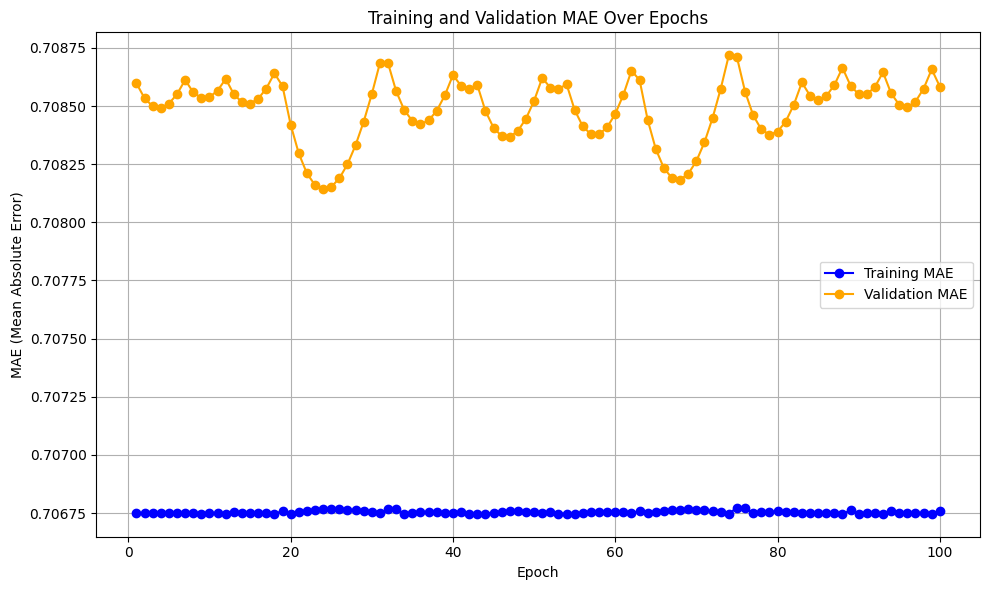

In [ ]:
# Initialize lists to store MAE for training and validation
train_losses = []
val_losses = []

# Training loop
num_epochs = 100
best_val_loss = float('inf')  # Track the best validation loss
best_model = None

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            out = model(batch)
            loss = criterion(out, batch.y)
            val_loss += loss.item()

    # Calculate average loss
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    # Store losses for visualization
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()

# Plot MAE over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training MAE', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation MAE', color='orange', marker='o')
plt.xlabel('Epoch')
plt.ylabel('MAE (Mean Absolute Error)')
plt.title('Training and Validation MAE Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("mae_training_validation.png", dpi=300)
plt.show()
